In [6]:
import warnings
warnings.filterwarnings('ignore')
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [28]:
labels_pd = pd.read_csv("labels.csv")
print(labels_pd.head(20))
counts_pd = pd.read_csv("processed_counts.csv")
print(counts_pd.head())

               index                   bulk_labels
0   AAAGCCTGGCTAAC-1                CD14+ Monocyte
1   AAATTCGATGCACA-1                     Dendritic
2   AACACGTGGTCTTT-1                      CD56+ NK
3   AAGTGCACGTGCTA-1               CD4+/CD25 T Reg
4   ACACGAACGGAGTG-1                     Dendritic
5   ACAGTTCTTAGCCA-1                       CD19+ B
6   ACATTCTGACTACG-1                     Dendritic
7   ACCCTCGAGTGAGG-1                     Dendritic
8   ACTGGCCTTTTCGT-1              CD8+ Cytotoxic T
9   ACTTGGGAACCAGT-1                CD14+ Monocyte
10  AGAAAGTGTGAACC-1              CD8+ Cytotoxic T
11  AGATATTGACCACA-1           CD4+/CD45RO+ Memory
12  AGTAAGGATTTACC-1                       CD19+ B
13  AGTTAAACAAACAG-1                       CD19+ B
14  ATAACAACCTCTAT-1                CD14+ Monocyte
15  ATGGACACAAGTGA-1                       CD19+ B
16  ATGGACACTCGTTT-1                     Dendritic
17  ATGGGTACCTGGTA-1  CD8+/CD45RA+ Naive Cytotoxic
18  ATGTAAACTTTCGT-1           

In [8]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)
from sklearn.preprocessing import StandardScaler

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()

print(df.shape)
print(df.head())


(700, 766)
                   HES4  TNFRSF4  SSU72  PARK7   RBP7    SRM  MAD2L2  AGTRAP  \
AAAGCCTGGCTAAC-1 -0.326   -0.191 -0.728 -0.301  3.386 -0.531   2.016   3.377   
AAATTCGATGCACA-1  1.171   -0.191  0.795 -1.200 -0.174 -0.531   1.889  -0.486   
AACACGTGGTCTTT-1 -0.326   -0.191  0.483 -1.200 -0.174 -0.531  -0.451   0.971   
AAGTGCACGTGCTA-1 -0.326   -0.191  1.134 -0.157 -0.174 -0.531  -0.451  -0.486   
ACACGAACGGAGTG-1 -0.326   -0.191 -0.728 -0.607 -0.174 -0.531  -0.451   0.787   

                  TNFRSF1B  EFHD2  ...  MRPS6   TTC3  U2AF1   CSTB  SUMO3  \
AAAGCCTGGCTAAC-1     4.841 -0.525  ... -0.532 -0.341  0.303  1.404  4.294   
AAATTCGATGCACA-1    -0.459 -0.525  ... -0.532 -0.341 -0.905  2.849 -0.585   
AACACGTGGTCTTT-1    -0.459  2.286  ...  2.606 -0.341 -0.905 -0.455 -0.585   
AAGTGCACGTGCTA-1    -0.459 -0.525  ... -0.532 -0.341 -0.905 -0.119 -0.585   
ACACGAACGGAGTG-1    -0.459  1.932  ...  0.839  1.679 -0.108 -0.534 -0.585   

                  ITGB2  S100B  PRMT2  MT-ND3

One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [32]:
from sklearn.preprocessing import StandardScaler
df['cell type'] = df['bulk_labels']

categories = df['cell type'].unique()
print(categories)
original_labels = np.array([categories[np.argmax(row)] for row in y])

y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['cell type']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop(['cell type', 'bulk_labels'], axis=1).values
print(X)
#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]


scaler = StandardScaler()
X_all = np.concatenate([X_train, X_test], axis=0)
X_all_scaled = scaler.fit_transform(X_all)
X_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)


['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']
[[-0.326 -0.191 -0.728 ... -0.21  -0.636  4.011]
 [ 1.171 -0.191  0.795 ... -0.21   2.63  -0.49 ]
 [-0.326 -0.191  0.483 ... -0.21   0.663 -0.49 ]
 ...
 [-0.326 -0.191 -0.728 ... -0.21  -0.636  1.226]
 [-0.326 -0.191 -0.728 ... -0.21  -0.636 -0.49 ]
 [-0.326 -0.191  0.148 ... -0.21  -0.636 -0.49 ]]


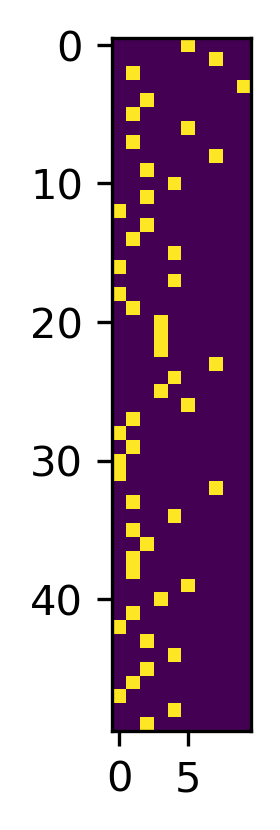

In [33]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [34]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):  # Use 64 if you trained with that
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # MUST include dropout if used in training
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

input_dim = X_all_scaled.shape[1]
model = Autoencoder(input_dim=input_dim, latent_dim=64)
model.load_state_dict(torch.load("autoencoder_model_ALL.pt"))
model.eval()

#get latent space
with torch.no_grad():
    _, Z = model(X_tensor)

Z_np = Z.cpu().numpy()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(original_labels)

Z_train, Z_test, y_train, y_test = train_test_split(
    Z_np, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [36]:
import numpy as np
print("y_train class distribution:", np.bincount(y_train))
print("y_test class distribution:", np.bincount(y_test))


y_train class distribution: [103  76  11  54   7  15  25  43  34 192]
y_test class distribution: [26 19  2 14  1  4  6 11  9 48]


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(Z_train, y_train)

# Best results
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV accuracy: 0.7982142857142855


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# has the parameters from grid searcch
clf_z = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=None,
    random_state=42
)


clf_z.fit(Z_train, y_train)
y_pred_z = clf_z.predict(Z_test)

print("RF latent space accuracy:", accuracy_score(y_test, y_pred_z))
print(classification_report(y_test, y_pred_z, target_names=le.classes_))


RF latent space accuracy: 0.8142857142857143
                              precision    recall  f1-score   support

              CD14+ Monocyte       0.82      0.88      0.85        26
                     CD19+ B       0.95      1.00      0.97        19
                       CD34+       1.00      1.00      1.00         2
             CD4+/CD25 T Reg       0.59      0.93      0.72        14
  CD4+/CD45RA+/CD25- Naive T       0.00      0.00      0.00         1
         CD4+/CD45RO+ Memory       0.00      0.00      0.00         4
                    CD56+ NK       1.00      0.50      0.67         6
            CD8+ Cytotoxic T       0.64      0.64      0.64        11
CD8+/CD45RA+ Naive Cytotoxic       0.80      0.44      0.57         9
                   Dendritic       0.88      0.90      0.89        48

                    accuracy                           0.81       140
                   macro avg       0.67      0.63      0.63       140
                weighted avg       0.80    

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'hidden_layer_sizes': [(64,), (128, 64), (128, 64, 32), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate_init': [0.001, 0.01]
}


mlp = MLPClassifier(max_iter=1000, random_state=42, verbose=True)
grid = GridSearchCV(
    mlp,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
verbose=2)
grid.fit(Z_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Iteration 1, loss = 3.93540125
Iteration 2, loss = 3.46321496
Iteration 3, loss = 3.05343404
Iteration 4, loss = 2.68496147
Iteration 5, loss = 2.35445456
Iteration 6, loss = 2.07064986
Iteration 7, loss = 1.82474436
Iteration 8, loss = 1.61027427
Iteration 9, loss = 1.42609165
Iteration 10, loss = 1.27021002
Iteration 11, loss = 1.13944748
Iteration 12, loss = 1.03083853
Iteration 13, loss = 0.94121100
Iteration 14, loss = 0.87255608
Iteration 15, loss = 0.81500373
Iteration 16, loss = 0.76906063
Iteration 17, loss = 0.73142376
Iteration 18, loss = 0.69708580
Iteration 19, loss = 0.66470391
Iteration 20, loss = 0.63742651
Iteration 21, loss = 0.61287932
Iteration 22, loss = 0.58981141
Iteration 23, loss = 0.56923708
Iteration 24, loss = 0.55172598
Iteration 25, loss = 0.53433154
Iteration 26, loss = 0.51776951
Iteration 27, loss = 0.50276759
Iteration 28, loss = 0.48941311
Iteration 29, loss = 0.47608887
Iteration 30, loss 

In [78]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

mlp_z = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='tanh',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,

)

mlp_z.fit(Z_train, y_train)
y_pred_mlp = mlp_z.predict(Z_test)

print("MLP latent space accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))


MLP latent space accuracy: 0.8357142857142857
                              precision    recall  f1-score   support

              CD14+ Monocyte       0.85      0.85      0.85        26
                     CD19+ B       1.00      0.95      0.97        19
                       CD34+       1.00      1.00      1.00         2
             CD4+/CD25 T Reg       0.62      0.93      0.74        14
  CD4+/CD45RA+/CD25- Naive T       0.00      0.00      0.00         1
         CD4+/CD45RO+ Memory       0.00      0.00      0.00         4
                    CD56+ NK       1.00      0.67      0.80         6
            CD8+ Cytotoxic T       0.80      0.73      0.76        11
CD8+/CD45RA+ Naive Cytotoxic       0.86      0.67      0.75         9
                   Dendritic       0.88      0.92      0.90        48

                    accuracy                           0.84       140
                   macro avg       0.70      0.67      0.68       140
                weighted avg       0.83   

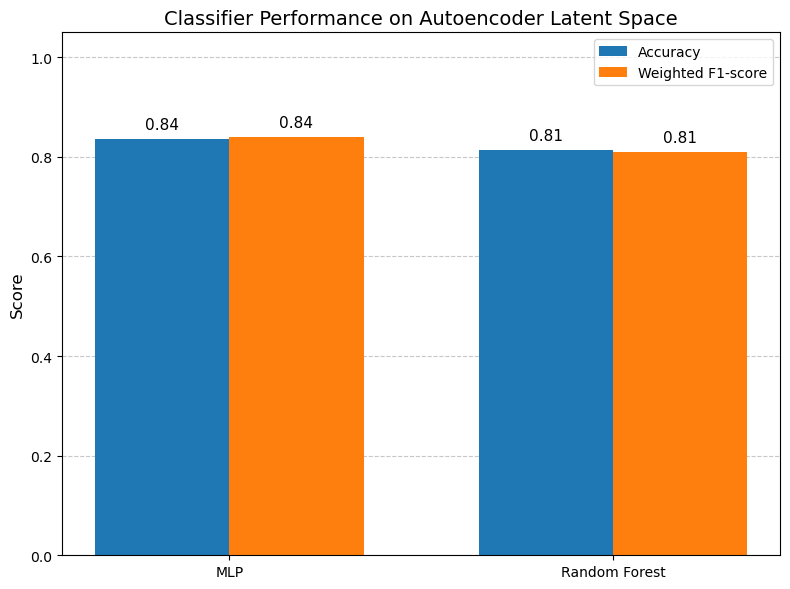

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
classifiers = ['MLP', 'Random Forest']
accuracy_scores = [0.8357142857142857, 0.814285714285714]
f1_scores = [0.84, 0.81]

x = np.arange(len(classifiers))  
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 6))
acc_bars = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
f1_bars = ax.bar(x + width/2, f1_scores, width, label='Weighted F1-score')

# Add text labels on bars
for bars in [acc_bars, f1_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=11)

# Formatting
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1.05)
ax.set_title('Classifier Performance on Autoencoder Latent Space', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


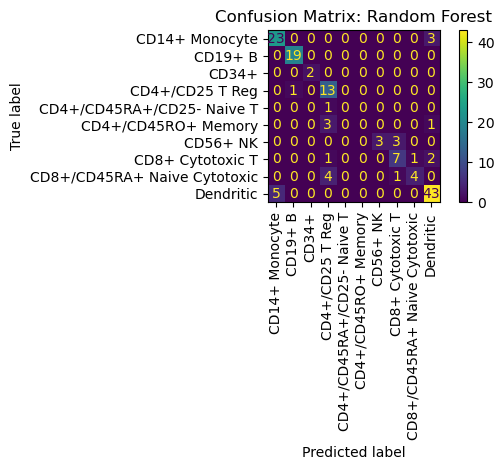

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf_z, Z_test, y_test, display_labels=le.classes_, xticks_rotation='vertical')
plt.title("Confusion Matrix: Random Forest")
plt.tight_layout()
plt.show()


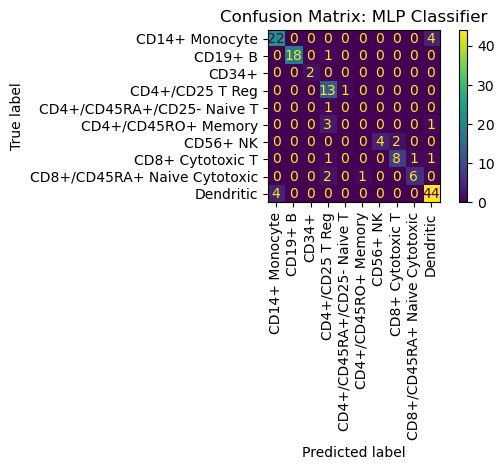

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    mlp_z, 
    Z_test, 
    y_test, 
    display_labels=le.classes_, 
    xticks_rotation='vertical',
)
plt.title("Confusion Matrix: MLP Classifier")
plt.tight_layout()
plt.show()
